In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [70]:
DEVICE = "mps"

# Load Dataset

In [71]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as torch_data

transform_to_tensor = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST("./MNIST_dataset/", transform=transform_to_tensor, train= True, download=True)
val_dataset = MNIST("./MNIST_dataset/", transform=transform_to_tensor, train= False, download=True)


In [72]:
train_dataloader = torch_data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch_data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

# Check MNIST data

Text(0.5, 1.0, '7')

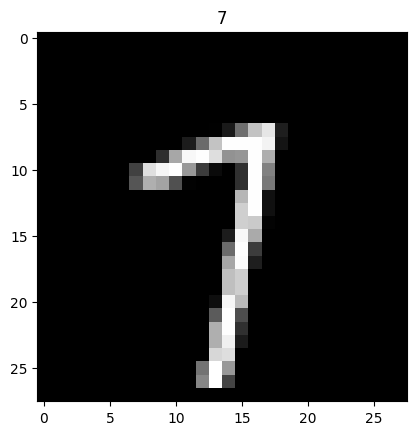

In [73]:
plt.imshow(train_dataset[42][0][0], cmap="gray", interpolation="nearest")
plt.title(f"{train_dataset[42][1]}")

In [74]:
print(f"size train dataset {len(train_dataset)}")
print(f"size val dataset {len(val_dataset)}")

size train dataset 60000
size val dataset 10000


# Model (not the most important part)

In [75]:
class UNetBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(UNetBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
    


In [76]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [77]:
class MyUNet(nn.Module):
    def __init__(self, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = SinusoidalPosEmb(time_emb_dim)
        
        # First half
        self.te1 = mlp_time_embedding(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            UNetBlock((1, 28, 28), 1, 10),
            UNetBlock((10, 28, 28), 10, 10),
            UNetBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = mlp_time_embedding(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            UNetBlock((10, 14, 14), 10, 20),
            UNetBlock((20, 14, 14), 20, 20),
            UNetBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = mlp_time_embedding(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            UNetBlock((20, 7, 7), 20, 40),
            UNetBlock((40, 7, 7), 40, 40),
            UNetBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = mlp_time_embedding(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            UNetBlock((40, 3, 3), 40, 20),
            UNetBlock((20, 3, 3), 20, 20),
            UNetBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = mlp_time_embedding(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            UNetBlock((80, 7, 7), 80, 40),
            UNetBlock((40, 7, 7), 40, 20),
            UNetBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = mlp_time_embedding(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            UNetBlock((40, 14, 14), 40, 20),
            UNetBlock((20, 14, 14), 20, 10),
            UNetBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = mlp_time_embedding(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            UNetBlock((20, 28, 28), 20, 10),
            UNetBlock((10, 28, 28), 10, 10),
            UNetBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

def mlp_time_embedding(dim_in, dim_out)-> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out)
    )


In [91]:
class Diffusion(nn.Module):
    def __init__(self, model, n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times

        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)
                                     
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
    
    def extract(self, a, t, x_shape):
        """
            This function will be used to extract alphas and betas at time t.
            Basically, it gets the value of t, select the corresponding value of the tensor a at the index t, and reshape it to match the value of x. This tensor's broadcasting help for hadamard product.
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        perturbed_images = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return perturbed_images.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep:torch.Tensor, t: int):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, 1, 28, 28)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    


In [92]:
model = MyUNet(time_emb_dim=256)


In [93]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

539768

In [94]:

diffusion = Diffusion(model, n_times=1000, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=3e-4)
denoising_loss = nn.MSELoss()

In [95]:
model.eval()
for batch_idx, (x, _) in enumerate(val_dataloader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

tensor([0.9999, 0.9999, 0.9998, 0.9997, 0.9997, 0.9996, 0.9994, 0.9993, 0.9992,
        0.9991, 0.9989, 0.9987, 0.9986, 0.9984, 0.9982, 0.9980, 0.9978, 0.9976,
        0.9973, 0.9971, 0.9969, 0.9966, 0.9963, 0.9961, 0.9958, 0.9955, 0.9952,
        0.9948, 0.9945, 0.9942, 0.9938, 0.9935, 0.9931, 0.9927, 0.9924, 0.9920,
        0.9916, 0.9911, 0.9907, 0.9903, 0.9898, 0.9894, 0.9889, 0.9884, 0.9880,
        0.9875, 0.9870, 0.9865, 0.9859, 0.9854, 0.9849, 0.9843, 0.9838, 0.9832,
        0.9826, 0.9820, 0.9814, 0.9808, 0.9802, 0.9796, 0.9789, 0.9783, 0.9776,
        0.9770, 0.9763, 0.9756, 0.9749, 0.9742, 0.9735, 0.9728, 0.9721, 0.9713,
        0.9706, 0.9698, 0.9691, 0.9683, 0.9675, 0.9667, 0.9659, 0.9651, 0.9643,
        0.9635, 0.9626, 0.9618, 0.9610, 0.9601, 0.9592, 0.9583, 0.9575, 0.9566,
        0.9556, 0.9547, 0.9538, 0.9529, 0.9519, 0.9510, 0.9500, 0.9491, 0.9481,
        0.9471, 0.9461, 0.9451, 0.9441, 0.9431, 0.9421, 0.9410, 0.9400, 0.9389,
        0.9379, 0.9368, 0.9358, 0.9347, 

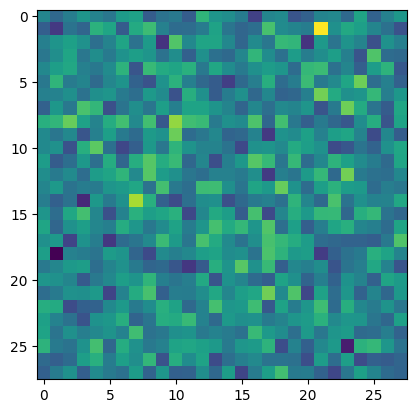

In [51]:
plt.imshow(perturbed_images.cpu()[6][0])

In [57]:
print("Start training DDPMs...")
model.train()
epochs = 3
for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)
        
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


100%|██████████| 1875/1875 [03:08<00:00,  9.93it/s]


	Epoch 1 complete! 	Denoising Loss:  0.03935545904307428


100%|██████████| 1875/1875 [03:09<00:00,  9.90it/s]


	Epoch 2 complete! 	Denoising Loss:  0.03765701786778955


100%|██████████| 1875/1875 [03:07<00:00, 10.01it/s]


	Epoch 3 complete! 	Denoising Loss:  0.036216894306814976


100%|██████████| 1875/1875 [03:08<00:00,  9.94it/s]


	Epoch 4 complete! 	Denoising Loss:  0.035178977526970835


100%|██████████| 1875/1875 [03:07<00:00,  9.97it/s]


	Epoch 5 complete! 	Denoising Loss:  0.033949947584988975


100%|██████████| 1875/1875 [03:07<00:00,  9.98it/s]


	Epoch 6 complete! 	Denoising Loss:  0.03352548296910213


100%|██████████| 1875/1875 [03:07<00:00, 10.00it/s]


	Epoch 7 complete! 	Denoising Loss:  0.0332456933430882


100%|██████████| 1875/1875 [03:08<00:00,  9.97it/s]


	Epoch 8 complete! 	Denoising Loss:  0.032531400122694676


100%|██████████| 1875/1875 [03:07<00:00,  9.98it/s]


	Epoch 9 complete! 	Denoising Loss:  0.031923813263815104


100%|██████████| 1875/1875 [03:08<00:00,  9.96it/s]

	Epoch 10 complete! 	Denoising Loss:  0.03175749518961239
Finish!!


In [58]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=32)


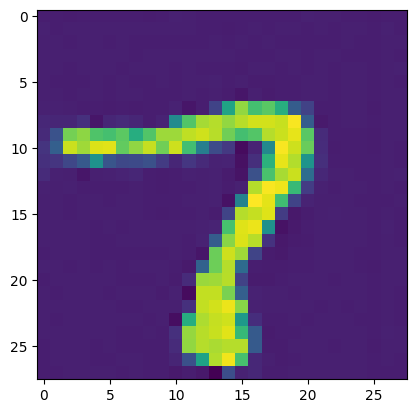

In [68]:
plt.imshow(generated_images[3][0].cpu())